# DataSynthesizer Usage (correlated attribute mode)

> This is a quick demo to use DataSynthesizer in correlated attribute mode.

### Step 1 import packages

In [1]:
import os
from time import time

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import pandas as pd

## get run time

In [2]:
def get_runtime(input_data, na_values, mode):
    description_file = f'./out/{mode}/description'
    description_file = description_file + '_' + input_data.split('.')[0] + '.json'
    synthetic_data = f'./out/{mode}/sythetic_data'
    synthetic_data = synthetic_data + '_' + input_data
    
    input_df = pd.read_csv(os.path.join('./data', input_data), skipinitialspace=True, na_values=na_values)
    cols_dict = {col: False for col in input_df.columns}
    categorical_attributes = (input_df.dtypes=='O').to_dict()

    # Default values set here, change here if needed.

    # An attribute is categorical if its domain size is less than this threshold.
    # Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
    threshold_value = 20

    # specify categorical attributes
    categorical_attributes = categorical_attributes  # {'native-country': True}

    # specify which attributes are candidate keys of input dataset.
    candidate_keys = cols_dict # {'index': True}

    # A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
    # change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
    # Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
    epsilon = 1

    # The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
    degree_of_bayesian_network = 2

    # Number of tuples generated in synthetic dataset.
    num_tuples_to_generate = input_df.shape[0] # Here 32561 is the same as input dataset, but it can be set to another number.

    ### Step 3 DataDescriber

    # 1. Instantiate a DataDescriber.
    # 2. Compute the statistics of the dataset.
    # 3. Save dataset description to a file on local machine.

    start = time()
    describer = DataDescriber(category_threshold=threshold_value, null_values=na_values)
    describer.describe_dataset_in_correlated_attribute_mode(dataset_file=os.path.join('./data', input_data), 
                                                            epsilon=epsilon, 
                                                            k=degree_of_bayesian_network,
                                                            attribute_to_is_categorical=categorical_attributes,
                                                            attribute_to_is_candidate_key=candidate_keys)
    describer.save_dataset_description_to_file(description_file)
    duration_desc = time() - start

    ### Step 4 generate synthetic dataset

    # 1. Instantiate a DataGenerator.
    # 2. Generate a synthetic dataset.
    # 3. Save it to local machine.

    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
    generator.save_synthetic_data(synthetic_data)
    duration_tot = time() - start
    print('took {} seconds'.format(duration_tot))
    return duration_desc, duration_tot


### Step 2 user-defined parameteres

In [3]:
files = os.listdir('./data')
files = sorted([file for file in files if file.split('_')[0] == 'synth'])
files = sorted([file for file in files if file.split('_')[2] in ['10', '15', '25', '30']])
na_values = {}
mode = 'correlated_attribute_mode'
files

['synth_100000_10_5_2_2_10_0_20.csv',
 'synth_100000_15_5_2_2_10_0_20.csv',
 'synth_100000_25_10_5_5_10_0_20.csv',
 'synth_100000_30_10_5_5_10_0_20.csv']

In [4]:
duration = []
for input_data in files:
    duration_ = get_runtime(input_data, na_values, mode)
    duration.append(duration_)

================ Constructing Bayesian Network (BN) ================
Adding ROOT 0
Adding attribute y
Adding attribute 4
Adding attribute 3
Adding attribute 2
Adding attribute 9
Adding attribute 1
Adding attribute 7
Adding attribute 5
Adding attribute 8
Adding attribute 6
========================== BN constructed ==========================
took 133.45550894737244 seconds
================ Constructing Bayesian Network (BN) ================
Adding ROOT 10
Adding attribute 13
Adding attribute 4
Adding attribute y
Adding attribute 8
Adding attribute 0
Adding attribute 14
Adding attribute 2
Adding attribute 5
Adding attribute 11
Adding attribute 6
Adding attribute 9
Adding attribute 1
Adding attribute 3
Adding attribute 7
Adding attribute 12
========================== BN constructed ==========================
took 464.86610293388367 seconds
================ Constructing Bayesian Network (BN) ================
Adding ROOT 4
Adding attribute y
Adding attribute 12
Adding attribute 19
Adding att

In [5]:
import numpy as np
df = pd.DataFrame(np.vstack([file.split('.csv')[0].split('_')[1:] for file in files]),
                    columns=['n_samples','n_features','n_informative',
                            'n_redundant','n_repeated','n_classes',
                            'ncat', 'nbins'])
for col in df.columns:
    df[col] = df[col].astype(int)

#df[['duration_desc', 'duration_tot']] = np.vstack(duration)

df = df.iloc[:len(duration),:]
df[['duration_desc', 'duration_tot']] = np.vstack(duration)
df


,n_samples,n_features,n_informative,n_redundant,n_repeated,n_classes,ncat,nbins,duration_desc,duration_tot
0,100000,10,5,2,2,10,0,20,102.074113,133.455509
1,100000,15,5,2,2,10,0,20,417.466134,464.866103
2,100000,25,10,5,5,10,0,20,2911.113018,3003.049653
3,100000,30,10,5,5,10,0,20,6017.308064,6138.410539


In [6]:
#df.to_csv('./out/correlated_attribute_mode/duration_per_nfeat_ncat_10cls.csv', index=False)

In [14]:
df_old = pd.read_csv('./out/correlated_attribute_mode/duration_per_nfeat_ncat_10cls.csv')
df = pd.concat([df_old, df])

,n_features,duration_tot
0,10,133.455509
1,15,464.866103
0,20,1208.393316
2,25,3003.049653
3,30,6138.410539
10,40,16845.123520


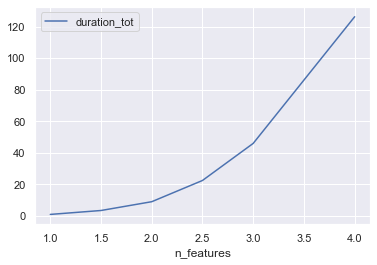

In [17]:
df.loc[df.ncat==0, ['n_features', 'duration_tot']] \
.sort_values('n_features') \
.multiply(1 / df.loc[df.ncat==0, ['n_features', 'duration_tot']].min()).plot(x='n_features', y='duration_tot')
df.loc[df.ncat==0, ['n_features', 'duration_tot']].sort_values('n_features')#.plot(x='n_features', y='duration_tot')

In [49]:
1 * (1 + .3)**(df.loc[df.ncat==0, ['n_features', 'duration_tot']].sort_values('n_features')).n_features

0        13.785849
1        51.185893
0       190.049638
2       705.641001
3      2619.995644
10    36118.864808
Name: n_features, dtype: float64

In [39]:
df.loc[df.ncat==0, ['n_features', 'duration_tot']] \
.sort_values('n_features')#\
#.multiply(1 / df.loc[df.ncat==0, ['n_features', 'duration_tot']].min())

,n_features,duration_tot
0,10,133.455509
1,15,464.866103
0,20,1208.393316
2,25,3003.049653
3,30,6138.410539
10,40,16845.123520
